In [37]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pandas as pd
import pyccl
import pickle
import os
os.chdir("..")

from scripts.ks_flat import ks93, ks93inv
from scripts.mapmaking import eq2ang, project_healpix, bin_shear_map
from scripts.wf_flat import compute_s_from_theory, spin_wiener_filter

In [ ]:
### insert your own path here ###
local_path = '/global/homes/n/ngrewal/hos_mass_mapping/notebooks'

In [39]:
# simulation box size info
box_width_deg = 5
box_width_pix = 375
box_width_arcmin = box_width_deg * 60 # arcmin
pixel_size_arcmin = box_width_arcmin / box_width_pix # arcmin/pixel
pixel_size_deg = pixel_size_arcmin / 60 # degree/pixel
box_size_rad = np.radians(box_width_deg) # radians
pixel_size_rad = np.radians(pixel_size_deg) # radians/pixel

# galaxy shape noise level in galaxies/pixels
sig = (0.26 / np.sqrt( (30/5) * pixel_size_arcmin**2)) # units of galaxies per pixel (30 galaxies per arcmin and 5 redshift bins)
sig

0.13268069440075547

### This script uses a [Wiener filter (WF)](https://arxiv.org/pdf/1109.0932) for _flat sky_ shear to convergence reconstruction:


WF uses the expected convergence field power spectrum (at a fiducial cosmology) and noise power spectrum. In Fourier space,


$ \tilde{\kappa} = \mathbf{SP}^\dagger \left[ \mathbf{PSP}^\dagger + \mathbf{N} \right]^{-1} \tilde{\gamma} $,


where $\textbf{S}$ is the covariance matrix of power spectrum signal, $\textbf{N}$ is the noise covariance matrix, and $\textbf{P}$ is the forward model:

$ \textbf{\textrm{P}} = \left( \frac{k_1^2 - k_2^2}{k^2} + i\frac{2k_1 k_2}{k^2} \right), $

where $k_1$ and $k_2$ are spatial frequencies.

<br>

##### 1. Generate shear maps

In [40]:
# load flat sky shear maps
with open(f"{local_path}/map_shear1_flat.obj", "rb") as f:
    gmap1 = pickle.load(f)

with open(f"{local_path}/map_shear2_flat.obj", "rb") as f:
    gmap2 = pickle.load(f)

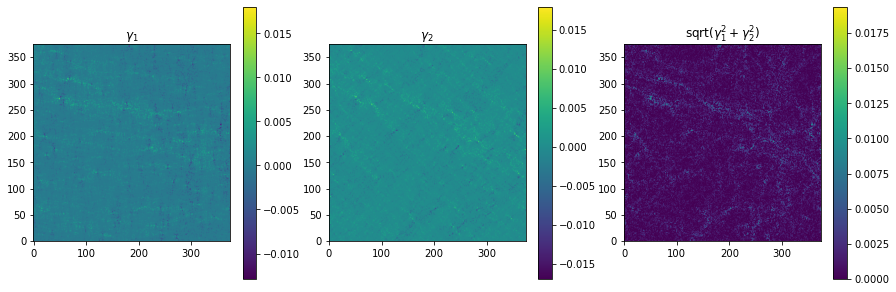

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
im1 = axes[0].imshow(gmap1, origin='lower')
fig.colorbar(im1, ax=axes[0])
axes[0].set_title(r"$\gamma_1$")
im2 = axes[1].imshow(gmap2, origin='lower')
fig.colorbar(im2, ax=axes[1])
axes[1].set_title(r"$\gamma_2$")
im3 = axes[2].imshow(np.sqrt(gmap1**2 + gmap2**2), origin='lower')
fig.colorbar(im3, ax=axes[2])
axes[2].set_title("sqrt($\gamma_1^2 + \gamma_2^2$)");

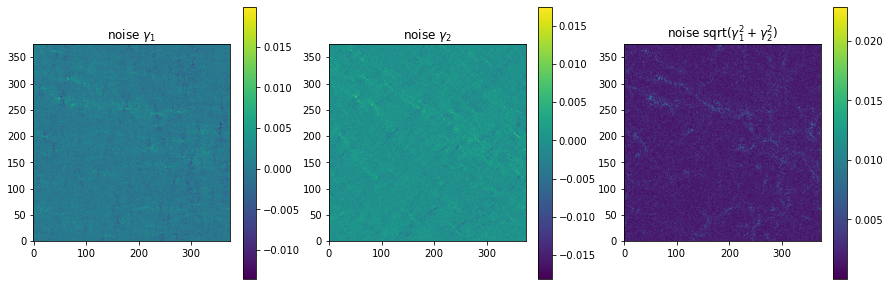

In [42]:
# add noise 
sig_test = sig/100 # use to test lower noise level
gmap1_noise = gmap1 + np.random.normal(loc = 0, scale = sig_test, size = gmap1.shape)
gmap2_noise = gmap2 + np.random.normal(loc = 0, scale = sig_test, size = gmap2.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
im1 = axes[0].imshow(gmap1_noise, origin='lower')
fig.colorbar(im1, ax=axes[0])
axes[0].set_title(r"noise $\gamma_1$")
im2 = axes[1].imshow(gmap2_noise, origin='lower')
fig.colorbar(im2, ax=axes[1])
axes[1].set_title(r"noise $\gamma_2$")
im3 = axes[2].imshow(np.sqrt(gmap1_noise**2 + gmap2_noise**2), origin='lower')
fig.colorbar(im3, ax=axes[2])
axes[2].set_title("noise sqrt($\gamma_1^2 + \gamma_2^2$)");

##### 2. Generate noise covariance matrix

In [43]:
# set noise covariance matrix
ncov_diag_Q = np.tile(sig ** 2, (box_width_pix, box_width_pix))
ncov_diag_U = np.tile(sig ** 2, (box_width_pix, box_width_pix))

#### 4. Generate fiducial cosmology signal power spectrum

In [44]:
# define fiducial cosmology - these values come from Table 1 in https://arxiv.org/pdf/1904.11966
Omega_m = 0.22
sigma8 = 0.8
w0 = -1.0
n_s = 0.9630
Omega_b = 0.04479
h = 0.71

# list of cosmological parameters
cosmo_params = [Omega_m, sigma8, w0, n_s, Omega_b, h]

# load redshift distribution
z = np.loadtxt(f'{local_path}/nz_sources_srd_5bins.txt')[:,0]
nz = np.loadtxt(f'{local_path}/nz_sources_srd_5bins.txt')[:,3]

# Load 1D power P(k) for theory E-mode signal power spectrum
input_ps_map_E = compute_s_from_theory(cosmo_params, z, nz, box_width_pix, box_size_rad, pixel_size_rad)
input_ps_map_B = np.zeros_like(input_ps_map_E)

##### 5. Run WF reconstruction

* Note: The same fiducial power spectrum can be used for non-fiducial convergence maps

In [45]:
wf = spin_wiener_filter(gmap1, gmap2, ncov_diag_Q, ncov_diag_U, input_ps_map_E, input_ps_map_B)
kE_wf, kB_wf = ks93(*wf)

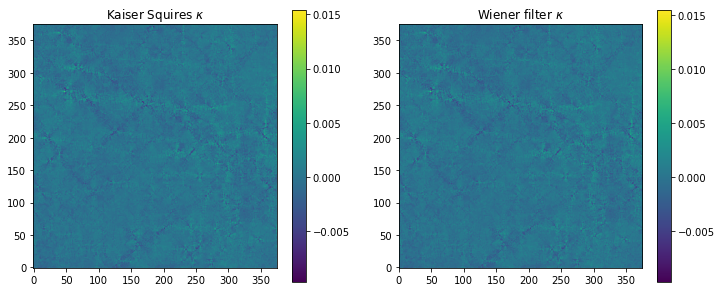

In [46]:
# KS comparison
kE_ks, kB_ks = ks93(gmap1, gmap2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(-kE_ks, origin='lower')
axes[0].set_title(r"Kaiser Squires $\kappa$")
fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(-kE_wf, origin='lower')
axes[1].set_title(r"Wiener filter $\kappa$")
fig.colorbar(im2, ax=axes[1]);

##### 6. Run WF reconstruction for noisy maps

In [47]:
# set noise covariance matrix
ncov_diag_Q_noise = np.tile(sig_test ** 2, (box_width_pix, box_width_pix))
ncov_diag_U_noise = np.tile(sig_test ** 2, (box_width_pix, box_width_pix))
wf_noise = spin_wiener_filter(gmap1_noise, gmap2_noise, ncov_diag_Q_noise, ncov_diag_U_noise, input_ps_map_E, input_ps_map_B)
kE_wf_noise, kB_wf_noise = ks93(*wf_noise)

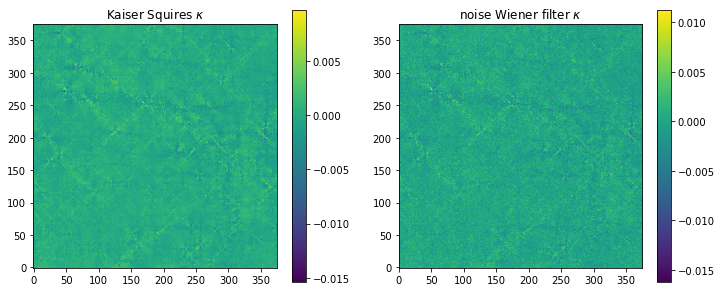

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(kE_ks, origin='lower')
axes[0].set_title(r"Kaiser Squires $\kappa$")
fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(kE_wf_noise, origin='lower')
axes[1].set_title(r"noise Wiener filter $\kappa$")
fig.colorbar(im2, ax=axes[1]);